## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Universal Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# size of tagged sentences
print(len(wsj))

3914


In [6]:
# creating a list for all the tags used in the corpus
tagged_words = [tup for sent in wsj for tup in sent]
tags =  [x[1] for x in tagged_words]

In [7]:
# most common tag
from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NOUN': 28867,
         '.': 11715,
         'NUM': 3546,
         'ADJ': 6397,
         'VERB': 13564,
         'DET': 8725,
         'ADP': 9857,
         'CONJ': 2265,
         'X': 6613,
         'ADV': 3171,
         'PRT': 3219,
         'PRON': 2737})

Nouns are the most common tag by a significant margin

In [11]:
# Splitting into train and test for the algorithm 
# A 95:5 split is being taken for train:test otherwise testing/validation will take a lot of time  

train_set, test_set = train_test_split(wsj,test_size=0.05,random_state=8)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('San', 'NOUN'), ('Francisco', 'NOUN'), ('voters', 'NOUN'), ('rejected', 'VERB'), ('a', 'DET'), ('new', 'ADJ'), ('ballpark', 'NOUN'), ('two', 'NUM'), ('years', 'NOUN'), ('ago', 'ADP'), ('.', '.')], [('Dr.', 'NOUN'), ('Kligman', 'NOUN'), ('patented', 'VERB'), ('the', 'DET'), ('medicine', 'NOUN'), ('while', 'ADP'), ('*-1', 'X'), ('employed', 'VERB'), ('*-2', 'X'), ('by', 'ADP'), ('the', 'DET'), ('University', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('later', 'ADJ'), ('licensed', 'VERB'), ('the', 'DET'), ('Retin-A', 'NOUN'), ('to', 'PRT'), ('a', 'DET'), ('division', 'NOUN'), ('of', 'ADP'), ('Johnson', 'NOUN'), ('&', 'CONJ'), ('Johnson', 'NOUN'), ('.', '.')], [('If', 'ADP'), ('Congress', 'NOUN'), ('takes', 'VERB'), ('the', 'DET'), ('dispute', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('Supreme', 'NOUN'), ('Court', 'NOUN'), ('-LRB-', '.'), ('*-2', 'X'), ('assuming', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('can', 'VERB'), ('establish', 'VERB'), ('standing', 'NOUN'), ('0', 'X'), ('*', 'X

In [12]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95377

In [13]:
# first 10 tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['San',
 'Francisco',
 'voters',
 'rejected',
 'a',
 'new',
 'ballpark',
 'two',
 'years',
 'ago']

In [14]:
# vocabulary / unique tokens
V = set(tokens)
print(len(V))

12055


In [15]:
# number of tags
# It will be 12 since this is the universal treebank dataset 
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [16]:
# the 12 tags
print(T)

{'ADJ', 'NOUN', 'CONJ', 'ADV', 'NUM', '.', 'ADP', 'X', 'PRT', 'PRON', 'VERB', 'DET'}


 The tag X is used for words that for some reason cannot be assigned a real part-of-speech category

The Viterbi algorithm is a variation of Hidden Markov models (HMM) with a greedy approach where it assigns the tag that is most likely at every word, rather than looking for the overall most likely sequence  
This algorithm finds the most likely sequence of hidden states, called the “Viterbi path,” conditioned on a sequence of observations in an HMM.

For each word, as per Viterbi algorithm, we need to first compute the probability; the order is T for that. And then the next step is to compute the maximum among the probabilities for that word, and the order for this step is also T.
This has to be done for n words in the sequence.

T^2+ T^2 + T^2
 .... n times

So, the time order complexity is O(nT^2).

### Emission Probabilities

In [12]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [13]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [14]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'JJ'))
print(word_given_tag('large', 'VB'))
print(word_given_tag('large', 'NN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NN'))
print(word_given_tag('will', 'VB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NN'))
print(word_given_tag('book', 'VB'))


 large
(0, 0)
(0, 0)
(0, 0) 


 will
(0, 0)
(0, 0)
(0, 0)

 book
(0, 0)
(0, 0)


### Transition Probabilities

In [15]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN', 'JJ'))
print(t2_given_t1('NN', 'DT'))
print(t2_given_t1('NNP', 'VB'))
print(t2_given_t1(',', 'NNP'))
print(t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))

(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)


In [17]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DT', '.'))
print(t2_given_t1('VBG', '.'))
print(t2_given_t1('NN', '.'))
print(t2_given_t1('NNP', '.'))


(0, 11000)
(0, 11000)
(0, 11000)
(0, 11000)


In [18]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [19]:
tags_matrix

array([[9.2363633e-02, 4.4272728e-02, 2.1827273e-01, 9.2090912e-02,
        2.6818182e-02, 5.2363638e-02, 2.4545453e-03, 1.7581818e-01,
        9.0363637e-02, 6.6818185e-02, 7.9636365e-02, 5.8636364e-02],
       [6.5402225e-02, 6.6710271e-02, 6.9735122e-01, 7.9136692e-02,
        2.1092217e-02, 4.7416613e-03, 1.0464355e-02, 4.9051666e-03,
        1.1935906e-02, 4.9051666e-04, 2.0601701e-02, 1.7168084e-02],
       [2.3790352e-01, 1.2370983e-02, 2.6374349e-01, 1.7769563e-01,
        2.9097430e-02, 1.7092453e-02, 4.4542860e-02, 1.3285996e-02,
        1.4757338e-01, 4.7580702e-03, 9.1135353e-03, 4.2822633e-02],
       [3.9577555e-02, 1.0689140e-01, 3.2291445e-01, 1.7175166e-02,
        3.4670364e-02, 1.3654790e-02, 1.2801365e-03, 3.2376787e-01,
        8.6409217e-03, 6.8380624e-02, 6.2193301e-02, 8.5342437e-04],
       [1.6359852e-01, 1.6968144e-02, 6.0509045e-02, 1.4422923e-01,
        7.5396188e-02, 2.6252601e-02, 1.8488875e-01, 5.4426126e-02,
        2.0505843e-01, 5.6347046e-02, 2.4011

In [20]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [21]:
tags_df

,.,ADJ,NOUN,ADP,X,ADV,PRT,DET,VERB,PRON,NUM,CONJ
.,0.092364,0.044273,0.218273,0.092091,0.026818,0.052364,0.002455,0.175818,0.090364,0.066818,0.079636,0.058636
ADJ,0.065402,0.066710,0.697351,0.079137,0.021092,0.004742,0.010464,0.004905,0.011936,0.000491,0.020602,0.017168
NOUN,0.237904,0.012371,0.263743,0.177696,0.029097,0.017092,0.044543,0.013286,0.147573,0.004758,0.009114,0.042823
ADP,0.039578,0.106891,0.322914,0.017175,0.034670,0.013655,0.001280,0.323768,0.008641,0.068381,0.062193,0.000853
X,0.163599,0.016968,0.060509,0.144229,0.075396,0.026253,0.184889,0.054426,0.205058,0.056347,0.002401,0.009925
ADV,0.134551,0.130233,0.031894,0.119934,0.022591,0.077741,0.014286,0.068439,0.346179,0.013953,0.032890,0.007309
PRT,0.042254,0.085162,0.248280,0.019980,0.013429,0.010481,0.001965,0.099902,0.400590,0.018015,0.057648,0.002293
DET,0.017231,0.206892,0.636342,0.009158,0.045909,0.012893,0.000241,0.005663,0.039523,0.003374,0.022292,0.000482
VERB,0.034223,0.066506,0.111206,0.091029,0.217523,0.082027,0.030343,0.135263,0.168710,0.035542,0.022505,0.005122
PRON,0.040462,0.073218,0.210405,0.022351,0.092486,0.034297,0.012331,0.008863,0.486320,0.007322,0.006936,0.005010


In [22]:
tags_df.loc['.', :]

.       0.092364
ADJ     0.044273
NOUN    0.218273
ADP     0.092091
X       0.026818
ADV     0.052364
PRT     0.002455
DET     0.175818
VERB    0.090364
PRON    0.066818
NUM     0.079636
CONJ    0.058636
Name: ., dtype: float32

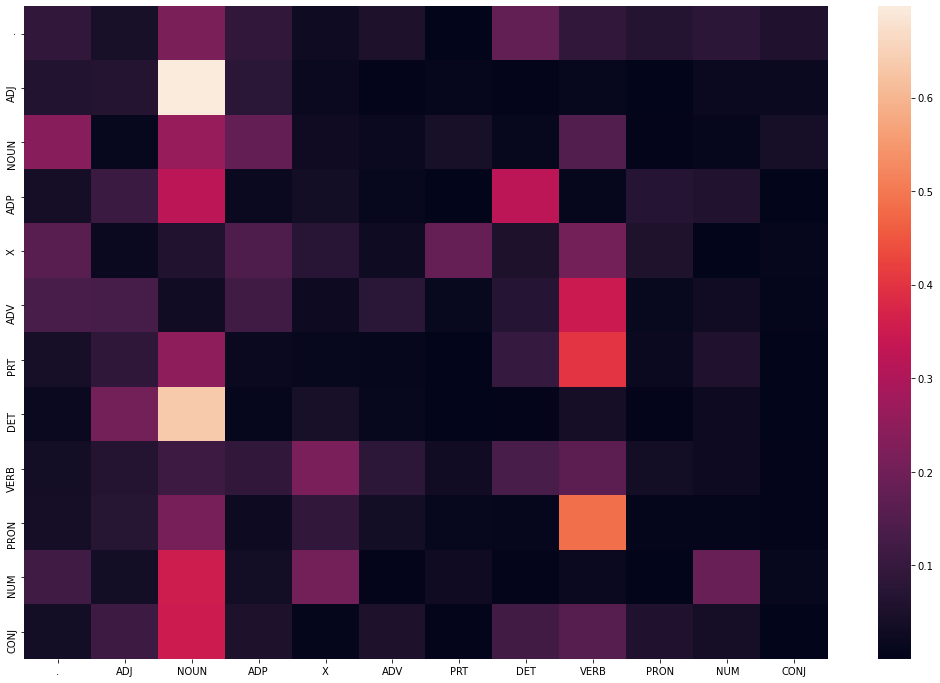

In [23]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


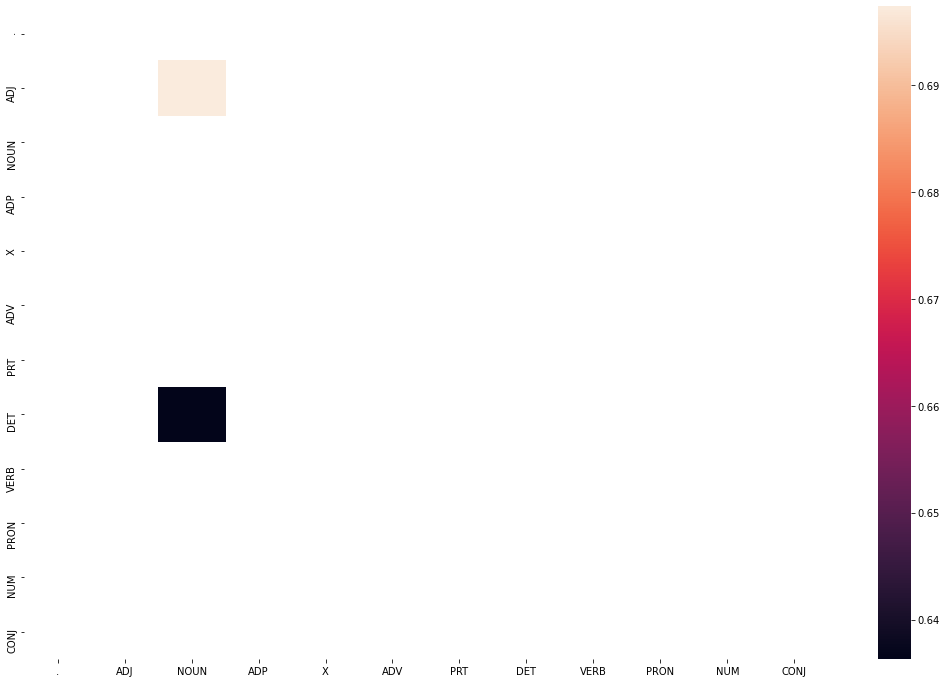

In [24]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Building the vanilla Viterbi based POS tagger

In [26]:
# Viterbi
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## Evaluating on Test Set

In [44]:
random.seed(1234)
test_run = test_set

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('There', 'DET'),
  ('are', 'VERB'),
  ('certain', 'ADJ'),
  ('cult', 'NOUN'),
  ('wines', 'NOUN'),
  ('that', 'DET'),
  ('*T*-163', 'X'),
  ('can', 'VERB'),
  ('command', 'VERB'),
  ('these', 'DET'),
  ('higher', 'ADJ'),
  ('prices', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('says', 'VERB'),
  ('*T*-1', 'X'),
  ('Larry', 'NOUN'),
  ('Shapiro', 'NOUN'),
  ('of', 'ADP'),
  ('Marty', 'NOUN'),
  ("'s", 'PRT'),
  (',', '.'),
  ('one', 'NUM'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('largest', 'ADJ'),
  ('wine', 'NOUN'),
  ('shops', 'NOUN'),
  ('in', 'ADP'),
  ('Dallas', 'NOUN'),
  ('.', '.')],
 [('Stock-index', 'NOUN'),
  ('options', 'NOUN'),
  ('--', '.'),
  ('Options', 'NOUN'),
  ('give', 'VERB'),
  ('holders', 'NOUN'),
  ('the', 'DET'),
  ('right', 'NOUN'),
  ('*RNR*-1', 'X'),
  (',', '.'),
  ('but', 'CONJ'),
  ('not', 'ADV'),
  ('the', 'DET'),
  ('obligation', 'NOUN'),
  ('*RNR*-1', 'X'),
  (',', '.'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('buy', 'VERB'),
  ('-LRB-', '.'),
  

In [45]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print(difference)

1293.7785720825195


In [46]:
# lets see the first 50 tags
print(tagged_seq[:50])

Time taken in seconds:  1293.7785720825195
[('``', '.'), ('There', 'DET'), ('are', 'VERB'), ('certain', 'ADJ'), ('cult', '.'), ('wines', 'NOUN'), ('that', 'ADP'), ('*T*-163', '.'), ('can', 'VERB'), ('command', 'NOUN'), ('these', 'DET'), ('higher', 'ADJ'), ('prices', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Larry', 'NOUN'), ('Shapiro', 'NOUN'), ('of', 'ADP'), ('Marty', '.'), ("'s", 'VERB'), (',', '.'), ('one', 'NUM'), ('of', 'ADP'), ('the', 'DET'), ('largest', 'ADJ'), ('wine', 'NOUN'), ('shops', 'NOUN'), ('in', 'ADP'), ('Dallas', 'NOUN'), ('.', '.'), ('Stock-index', 'NOUN'), ('options', 'NOUN'), ('--', '.'), ('Options', 'NOUN'), ('give', 'VERB'), ('holders', 'NOUN'), ('the', 'DET'), ('right', 'NOUN'), ('*RNR*-1', 'X'), (',', '.'), ('but', 'CONJ'), ('not', 'ADV'), ('the', 'DET'), ('obligation', 'NOUN'), ('*RNR*-1', 'X'), (',', '.'), ('*', 'X'), ('to', 'PRT'), ('buy', 'VERB'), ('-LRB-', '.'), ('a', 'DET'), ('call', 'NOUN'), ('-RRB-', '.'), ('or', 'CONJ'), ('se

In [47]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)

In [49]:
accuracy

0.9046989998112851

In [50]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [51]:
incorrect_tagged_cases

[[('certain', 'ADJ'), (('cult', '.'), ('cult', 'NOUN'))],
 [('wines', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-163', '.'), ('*T*-163', 'X'))],
 [('can', 'VERB'), (('command', 'NOUN'), ('command', 'VERB'))],
 [('of', 'ADP'), (('Marty', '.'), ('Marty', 'NOUN'))],
 [('Marty', 'NOUN'), (("'s", 'VERB'), ("'s", 'PRT'))],
 [('a', 'DET'), (('put', 'VERB'), ('put', 'NOUN'))],
 [('an', 'DET'), (('underlying', 'ADJ'), ('underlying', 'VERB'))],
 [('a', 'DET'), (('certin', '.'), ('certin', 'NOUN'))],
 [('The', 'DET'), (('following', 'VERB'), ('following', 'NOUN'))],
 [('L.', 'NOUN'), (('Cole', '.'), ('Cole', 'NOUN'))],
 [(',', '.'), (('Jackson', '.'), ('Jackson', 'NOUN'))],
 [(';', '.'), (('Rita', '.'), ('Rita', 'NOUN'))],
 [('Rita', 'NOUN'), (('Rae', '.'), ('Rae', 'NOUN'))],
 [('Rae', 'NOUN'), (('Cross', '.'), ('Cross', 'NOUN'))],
 [(',', '.'), (('Denver', '.'), ('Denver', 'NOUN'))],
 [('Richard', 'NOUN'), (('Meinders', '.'), ('Meinders', 'NOUN'))],
 [(',', '.'), (('

In [90]:
## Testing
sentence_test = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
words = word_tokenize(sentence_test)

start = time.time()
td_seq = Viterbi(words)
end = time.time()
difference = end-start

In [91]:
print(td_seq)
print(difference)

[('NASA', '.'), ('invited', '.'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', '.'), ('Satellite', '.'), ('.', '.')]
3.6088714599609375


### Solve the problem of unknown words

In [88]:
# most common tag
from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NOUN': 28867,
         '.': 11715,
         'NUM': 3546,
         'ADJ': 6397,
         'VERB': 13564,
         'DET': 8725,
         'ADP': 9857,
         'CONJ': 2265,
         'X': 6613,
         'ADV': 3171,
         'PRT': 3219,
         'PRON': 2737})

## Lets use a rule based tagger and add some of my own rules after looking at the incorrect cases. These rules will not be comprehensive therefore noun will be used for tagging words that are not tagged by the additional rules, since noun is the most frequent tag used in the corpus. 

In [62]:
def rule_based_Viterbi(test_words,tagged_seq, train_bag = train_tagged_words):
    start = time.time()
    word_bag = list(set([pair[0] for pair in train_bag]))
    
    words = [pair[0] for pair in tagged_seq]
    vtags = [pair[1] for pair in tagged_seq]
    
    for key, word in enumerate(words):
        if word not in word_bag:
            # words like eight-month ,revenue-desperate are adjectives for example : a five-day feast
            
            ## words ending with '-ous' usually are adjectives like ardous , serious 
            #, hilarious etc 
            
            if len(word.split('-'))==2 or word[-3:] == 'ous':
                vtags[key]='ADJ'
                
            # words ending with ly usually denote adverbs like simultaneously , hastily etc
            if word[-2:] == 'ly':
                vtags[key] = 'ADV'
            
            # most words ending with ing are verbs with some exceptions like king , string etc
            # since verbs make up a significant portion of ing words lets assign all to verbs
            
            #most words ending with ed are verbs like carried , stopped , handed 
            if word[-3:] == 'ing':
                vtags[key] = 'VERB'
            
            
            ## words like 250,000 or 0.456 are not treated as numbers because of the comma or . 
            elif (word.isdigit() == True or word.replace(',','').isdigit() or word.replace('.','').isdigit() or word.replace('.','').replace(',','').isdigit()):
                vtags[key] = 'NUM' 
                
            else: 
                # if this part is reached then additional rules need to be made 
                # so by default noun will be assigned based on its substantially high frequency
                vtags[key] = 'NOUN'
    end = time.time()
    difference = end-start
    print('Done',difference)
    
    return list(zip(words, vtags))

In [64]:
rule_based_pred = rule_based_Viterbi(test_tagged_words,tagged_seq,)

Done 0.6821427345275879


In [65]:
# accuracy
check = [i for i, j in zip(rule_based_pred, test_run_base) if i == j] 

In [66]:
accuracy = len(check)/len(rule_based_pred)

#### Evaluating tagging accuracy

In [67]:
accuracy

0.9522551424797131

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

rule based viterbi : 0.9522551424797131  
vanilla viterbi : 0.9046989998112851

In [76]:
incorrect_tagged_cases_rule_based = [[test_run_base[i-1],j] for i, j in enumerate(zip(rule_based_pred, test_run_base)) if j[0]!=j[1]]

In [77]:
incorrect_tagged_cases_rule_based

[[('wines', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-163', 'NOUN'), ('*T*-163', 'X'))],
 [('can', 'VERB'), (('command', 'NOUN'), ('command', 'VERB'))],
 [('Marty', 'NOUN'), (("'s", 'VERB'), ("'s", 'PRT'))],
 [('a', 'DET'), (('put', 'VERB'), ('put', 'NOUN'))],
 [('an', 'DET'), (('underlying', 'ADJ'), ('underlying', 'VERB'))],
 [('The', 'DET'), (('following', 'VERB'), ('following', 'NOUN'))],
 [(',', '.'), (('five-day', 'NOUN'), ('five-day', 'ADJ'))],
 [('and', 'CONJ'), (('eight-month', 'NOUN'), ('eight-month', 'ADJ'))],
 [('and', 'CONJ'), (('one-week', 'NOUN'), ('one-week', 'ADJ'))],
 [('and', 'CONJ'), (('90-day', 'NOUN'), ('90-day', 'ADJ'))],
 [('and', 'CONJ'), (('15-day', 'NOUN'), ('15-day', 'ADJ'))],
 [('--', '.'), (('and', 'CONJ'), ('and', 'NOUN'))],
 [('what', 'PRON'), (('*T*-172', 'NOUN'), ('*T*-172', 'X'))],
 [('a', 'DET'), (('vitriolic', 'NOUN'), ('vitriolic', 'ADJ'))],
 [('temporarily', 'ADV'), (('mollified', 'NOUN'), ('mollified', 'VERB'))],
 [('

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [84]:
# showing at least 5 cases where the new rule based tagger corrected the valnilla tagger's mistake
# change the limit for count / remove count to view all corrested cases
count=0
for cases in incorrect_tagged_cases:
        found = False
        # If still present in incorrect tag
        for rule_cases in incorrect_tagged_cases_rule_based:
            if cases[1] == rule_cases[1]: 
                found = True
                break
        if found == False: 
            # If tag is now correct
            for c in rule_based_pred:
                if c == cases[1][1]: 
                    count=count+1
                    print(count)
                    print("Incorrect: " + str(cases[1][0]))
                    print("Corrected now: " + str(c))
        if count>5:
            break

1
Incorrect: ('250,000', 'NOUN')
Corrected now: ('250,000', 'NUM')
2
Incorrect: ('functioning', 'NOUN')
Corrected now: ('functioning', 'VERB')
3
Incorrect: ('830,000', 'NOUN')
Corrected now: ('830,000', 'NUM')
4
Incorrect: ('1.20', 'NOUN')
Corrected now: ('1.20', 'NUM')
5
Incorrect: ('1.14', 'NOUN')
Corrected now: ('1.14', 'NUM')
6
Incorrect: ('490', 'NOUN')
Corrected now: ('490', 'NUM')


## Lets try a probabilistic method which tackles the problem of state probability becoming 0 for words the tagger has never seen before

This is because for unknown words the emission prob is 0 

   state prob = emission prob * transition prob  
=> state prob  = 0

Since the state prob becomes 0 the pmax(getting state for which prob is maximum) will be 0 and hence the index of list of tags will be 0 and the first one in the list will be selected as the tag

To cover for this possibility the following is used :  
If emission prob is 0 then the maximum transition prob is used to get most frequent tag in corpus.  
That is emission prob will be assumed as 1

In [69]:
def probabilistic_Viterbi(words, train_bag = train_tagged_words):
    start = time.time()
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            if word in V:
                state_probability = transition_p * emission_p              
            else:
                state_probability = transition_p
            
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    end = time.time()
    difference1 = end-start
    return list(zip(words, state))

In [70]:
prob_based_pred = probabilistic_Viterbi(test_tagged_words)

In [73]:
# accuracy
check = [i for i, j in zip(prob_based_pred, test_run_base) if i == j] 

In [74]:
accuracy = len(check)/len(prob_based_pred)

In [75]:
accuracy

0.9454614078127949

### Comparison  

prob based viterbi : 0.9454614078127949  
vanilla viterbi : 0.9046989998112851

In [85]:
incorrect_tagged_cases_prob_based = [[test_run_base[i-1],j] for i, j in enumerate(zip(prob_based_pred, test_run_base)) if j[0]!=j[1]]

In [86]:
incorrect_tagged_cases_prob_based

[[('wines', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-163', 'DET'), ('*T*-163', 'X'))],
 [('can', 'VERB'), (('command', 'NOUN'), ('command', 'VERB'))],
 [('of', 'ADP'), (('Marty', 'DET'), ('Marty', 'NOUN'))],
 [('Marty', 'NOUN'), (("'s", 'VERB'), ("'s", 'PRT'))],
 [('a', 'DET'), (('put', 'VERB'), ('put', 'NOUN'))],
 [('an', 'DET'), (('underlying', 'ADJ'), ('underlying', 'VERB'))],
 [('The', 'DET'), (('following', 'VERB'), ('following', 'NOUN'))],
 [(',', '.'), (('five-day', 'NOUN'), ('five-day', 'ADJ'))],
 [('and', 'CONJ'), (('eight-month', 'NOUN'), ('eight-month', 'ADJ'))],
 [('and', 'CONJ'), (('one-week', 'NOUN'), ('one-week', 'ADJ'))],
 [('$', '.'), (('250,000', 'NOUN'), ('250,000', 'NUM'))],
 [('and', 'CONJ'), (('90-day', 'NOUN'), ('90-day', 'ADJ'))],
 [('and', 'CONJ'), (('15-day', 'NOUN'), ('15-day', 'ADJ'))],
 [('--', '.'), (('and', 'CONJ'), ('and', 'NOUN'))],
 [('what', 'PRON'), (('*T*-172', 'VERB'), ('*T*-172', 'X'))],
 [('*T*-172', 'X'), (("'s", '

In [87]:
# showing at least 5 cases where the new prob based tagger corrected the valnilla tagger's mistake
# change the limit for count / remove count to view all corrested cases
count=0
for cases in incorrect_tagged_cases:
        found = False
        # If still present in incorrect tag
        for rule_cases in incorrect_tagged_cases_prob_based:
            if cases[1] == rule_cases[1]: 
                found = True
                break
        if found == False: 
            # If tag is now correct
            for c in prob_based_pred:
                if c == cases[1][1]: 
                    count=count+1
                    print(count)
                    print("Incorrect: " + str(cases[1][0]))
                    print("Corrected now: " + str(c))
        if count>5:
            break

1
Incorrect: ('mollified', 'NOUN')
Corrected now: ('mollified', 'VERB')
2
Incorrect: ('functioning', 'NOUN')
Corrected now: ('functioning', 'VERB')
3
Incorrect: ('Knowing', 'NOUN')
Corrected now: ('Knowing', 'VERB')
4
Incorrect: ('eat', 'NOUN')
Corrected now: ('eat', 'VERB')
5
Incorrect: ('Related', 'NOUN')
Corrected now: ('Related', 'VERB')
6
Incorrect: ('manage', 'NOUN')
Corrected now: ('manage', 'VERB')
